In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from dataset import DogDataset
from model import Generator, Discriminator

In [2]:
dogs_dir = '/home/cgl/data/generative-dog-images/square_crop_dogs'

In [3]:
G = Generator(100, 3)
D = Discriminator()

cuda = torch.cuda.is_available()
if cuda:
    print('Use GPU')
    G = G.cuda()
    D = D.cuda()
else:
    print('No GPU')

Use GPU


In [4]:
lr=1e-2
optimizer_G = torch.optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(D.parameters(), lr=lr)

In [5]:
img_size = (64, 64)
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64
trainloader = DataLoader(
    DogDataset(data_dir=dogs_dir, mode='train', ratio=0.8, transforms=image_transforms),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 10,
)

testloader = DataLoader(
    DogDataset(data_dir=dogs_dir, mode='test', ratio=0.8, transforms=image_transforms),
    batch_size=10,
    shuffle=False,
    num_workers=10
)

In [6]:
def show_batches(batch_images):
    images = torch.split(batch_images, [1]*batch_images.size(0), dim=0)
    images = torch.cat(images, dim=-1).squeeze().permute(1, 2, 0)
    images = images.cpu()
    plt.imshow(images)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


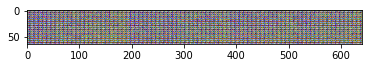

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


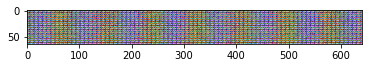

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


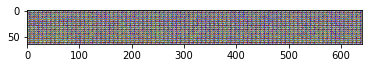

In [8]:
epoches = 60
for epoch in range(epoches):
    for i, img in enumerate(trainloader):
        signal = torch.randn(img.size(0), 100)
        real = torch.ones(img.size(0), 1)
        fake = torch.zeros(img.size(0), 1)
        if cuda:
            img, signal = img.cuda(), signal.cuda()
            real, fake = real.cuda(), fake.cuda()
        
        fake_img = G(signal)
        
        # train D
        optimizer_D.zero_grad()
        loss_real = -torch.mean(D(img))
        loss_fake = torch.mean(D(fake_img.detach()))
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()
        
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
        
        if i % 5 == 0:
            # train G
            optimizer_G.zero_grad()
            loss_G = -torch.mean(D(fake_img))
            loss_G.backward()
            optimizer_G.step()
        
        #if i % 100 == 0:
        #    print(f'[Epoch {epoch+1}/{epoches}]')
        #    print(f'[G loss: {loss_G.item()}] [D loss: {loss_D.item()} | loss_real: {loss_real.item()} loss_fake: {loss_fake.item()}]')
    
    if (epoch+1) % 20 == 0:
        with torch.no_grad():
            img = next(iter(testloader))
            signal = torch.randn(img.size(0), 100)
            if cuda:
                img, signal = img.cuda(), signal.cuda()
            fake_img = G(signal)
            show_batches(fake_img)